## Analysis of the network

I've tried to clean up this notebook as much as possible, but it's still pretty spaghetti-y

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [102]:
with open("Data/node_info.tsv") as f:
    raw_lines = f.readlines()
    processed = [row.split('\t') for row in raw_lines]
    
    nodes = {}
    
    for line in processed:
        lang = {}
        lang_id = int(line[0])
        
        lang["name"] = line[1]
        lang["year"] = int(line[2])
        lang["paradigm"] = eval(line[3])
        lang["typing"] = eval(line[4])
        
        nodes[lang_id] = lang

In [3]:
with open("Data/edges.txt") as f:
    raw_lines = f.readlines()
    edges = [tuple(map(int, row.split(" "))) for row in raw_lines]

In [4]:
minYear = np.inf
maxYear = -np.inf

for key in nodes:
    year = nodes[key]["year"]
    
    if year != 0 and year < minYear:
        minYear = year
    if year > maxYear:
        maxYear = year

print(minYear)
print(maxYear)

1948
2017


In [5]:
for key in nodes:
    if nodes[key]["year"] == minYear:
        print(nodes[key]["name"])

plankalkül


Load into a DiGraph

In [6]:
G = nx.DiGraph()
G.add_nodes_from(list(nodes.keys()))
G.add_edges_from(edges)

In [7]:
with_year_info = 0

for _, n in nodes.items():
    if n["year"] != 0:
        with_year_info += 1
print(with_year_info)

355


## 2.2 Technological Evolutionary Trees

In [8]:
def in_neighbors(G, i):
    return set([j for j, _ in G.in_edges(i)])

def influence(G, i, j, lamda=0.5, epsilon=1e-9):
    total = 0
    
    for k in in_neighbors(G, j):
        if k != i:
            total += lamda * s_a(G, i, k) + (1-lamda) * s_d(G, i, k)

    return max(epsilon, total)

def s_a(G, i, j):
    k_j = G.out_degree(j)
    
    if k_j == 0:
        return 0
    
    nodes = set(G.neighbors(i)) & set(G.neighbors(j))
    total = 0
    
    for l in nodes:
        total += 1/G.in_degree(l)
    return 1/k_j * total

def s_d(G, i, j):
    k_j = G.in_degree(j)
    
    if k_j == 0:
        return 0
    
    nodes = in_neighbors(G, i) & in_neighbors(G, j)
    total = 0
    
    for l in nodes:
        total += 1/G.out_degree(l)
    return 1/k_j * total

In [9]:
def clades(G):
    infs = {}
    ancestors = {}

    for i in G.nodes:
        infs[i] = 0
        ancestors[i] = 0

        for j in G.neighbors(i):
            inf = influence(G, i, j)
            if inf > infs[i]:
                infs[i] = inf
                ancestors[i] = j
    
    return infs, ancestors

## Temporal clades

In [10]:
temporal_nodes = set()

for nid, node in nodes.items():
    if node['year'] != 0:
        temporal_nodes.add(nid)

In [11]:
temporal_edges = []

for i, j in edges:
    if i in temporal_nodes and j in temporal_nodes:
        temporal_edges.append((i,j))

In [12]:
temporal_G = nx.DiGraph()
temporal_G.add_nodes_from(list(temporal_nodes))
temporal_G.add_edges_from(list(temporal_edges))

In [13]:
infs, ancestors = clades(temporal_G)
dropped_null = []

for i, j in ancestors.items():
    if i != 0 and j != 0:
        dropped_null.append((i,j))

temporal_clades = nx.DiGraph()
temporal_clades.add_nodes_from(list(temporal_nodes))
temporal_clades.add_edges_from(dropped_null)

### 3D tree visualization

In [14]:
clades_layout = nx.spring_layout(temporal_clades)

In [15]:
nodes[60614939]

{'name': '1c:enterprise programming language',
 'year': 0,
 'paradigm': [],
 'typing': []}

In [16]:
min_year = np.inf
max_year = -np.inf

for node in temporal_clades.nodes:
    val = nodes[node]
    min_year = min(val['year'], min_year)
    max_year = max(val['year'], max_year)

print(min_year)
print(max_year)

1948
2017


Set z according to the language's year

In [17]:
year_delta = max_year - min_year
layout_3d = {}

for node in clades_layout:
    z = 10 * (nodes[node]['year'] - min_year) / year_delta
    coords = np.append(clades_layout[node], z)
    layout_3d[node] = coords

In [18]:
subgraphs = list(nx.weakly_connected_component_subgraphs(temporal_clades))
subgraphs.sort(key=lambda x: x.size(), reverse=True)

### Fig 3 Stuff

In [19]:
from collections import defaultdict

In [20]:
min_year = np.inf
max_year = -np.inf

years = defaultdict(lambda: 0)
for lid in temporal_nodes:
    d = nodes[lid]
    years[d['year']] += 1
    min_year = min(d['year'], min_year)
    max_year = max(d['year'], max_year)

xs = list(range(min_year, max_year + 1))

In [21]:
year_influences = defaultdict(lambda: 0)
for lid in temporal_nodes:
    year = nodes[lid]["year"]
    
    year_influences[year] += len(list(temporal_G.neighbors(lid)))

In [22]:
ord_temp_nodes = list(temporal_nodes)
ord_temp_nodes.sort(key=lambda x: nodes[x]['year'])

In [23]:
import matplotlib.pyplot as plt

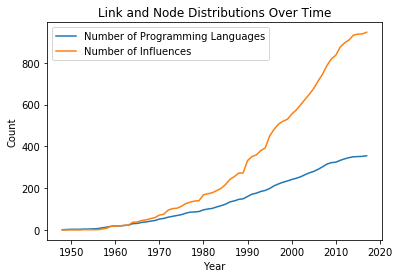

In [24]:
min_year = np.inf
max_year = -np.inf

years = defaultdict(lambda: 0)
for lid in temporal_nodes:
    d = nodes[lid]
    years[d['year']] += 1
    min_year = min(d['year'], min_year)
    max_year = max(d['year'], max_year)

xs = list(range(min_year, max_year + 1))

ys = [] # Number of languages
ls = [] # Number of links
acc = 0
accl = 0

for year in xs:
    acc += years[year]
#     accl += len(year_influences[year])
    accl += year_influences[year]
    ys.append(acc)
    ls.append(accl)

fig,ax = plt.subplots()
ax.plot(xs,ys, label="Number of Programming Languages")
ax.plot(xs,ls, label="Number of Influences")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Link and Node Distributions Over Time")
ax.legend()

In [25]:
for val in nodes.values():
    if val["name"] == "c#":
        print(val)

{'name': 'c#', 'year': 2000, 'paradigm': ['Structured', 'imperative', 'object-oriented', 'event-driven', 'task-driven', 'functional', 'generic', 'reflective', 'concurrent'], 'typing': ['static', 'dynamic', '[3]', 'strong', 'safe', 'nominative', 'partially inferred']}


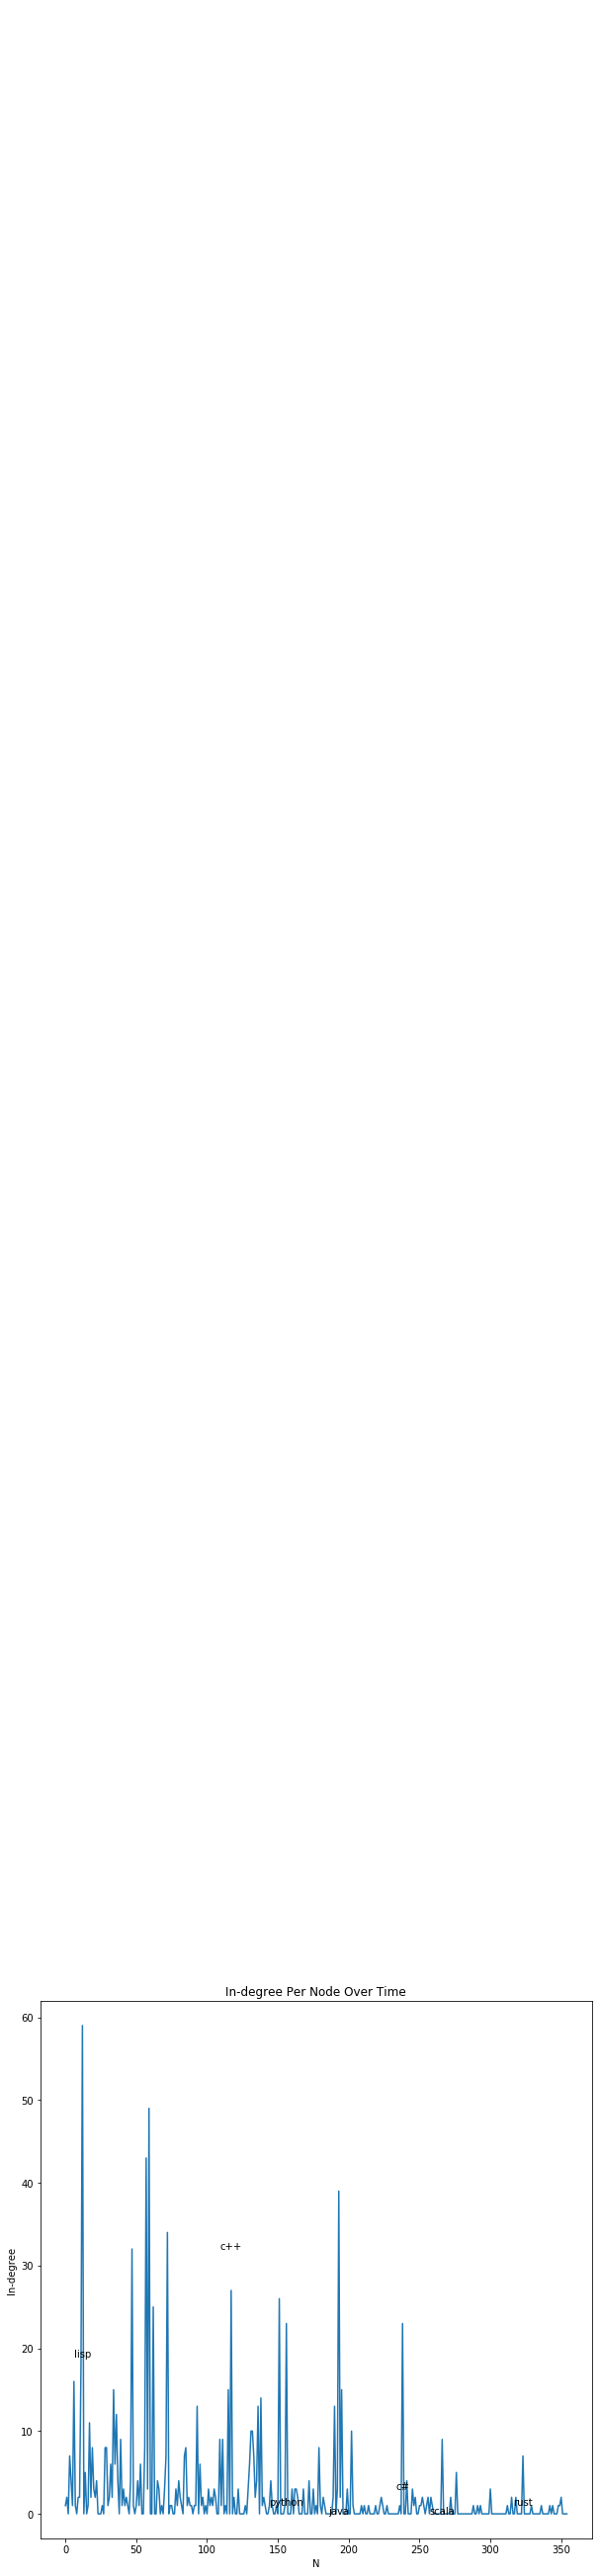

In [26]:
temporal_nodes_l = list(temporal_nodes)
temporal_nodes_l.sort(key=lambda x: nodes[x]['year'])

fig, ax = plt.subplots(figsize=(10,10))
xs = range(len(temporal_nodes_l))
special = ["lisp", "java", "python", "c", "c++", "c#", "scala", "rust"]
for i in range(len(temporal_nodes_l)):
    node = temporal_nodes_l[i]
    ys.append(temporal_G.in_degree(node))
    
    if nodes[node]["name"] in special:
        ax.annotate(nodes[node]['name'], (xs[i],ys[i]), ha='center')

ys = [temporal_G.in_degree(node) for node in temporal_nodes_l]
ax.set_ylabel("In-degree")
ax.set_xlabel("N")
ax.set_title("In-degree Per Node Over Time")
ax.plot(xs, ys)

/Users/eoin/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/eoin/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


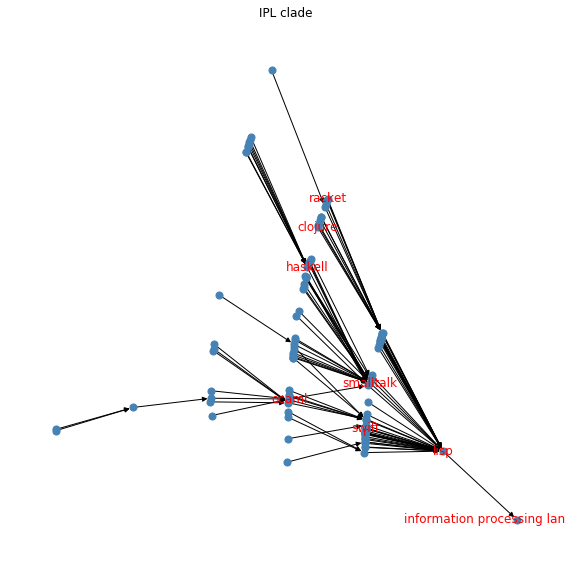

In [27]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Largest subgraph clade
subgraph = subgraphs[0]
# layout = nx.spectral_layout(subgraph)
# layout = nx.planar_layout(subgraph)

labels = defaultdict(lambda: 0)
stuff_to_label = set(["information processing language (ipl)", "lisp", "smalltalk", "haskell",
                      "ocaml", "racket", "swift", "clojure", "r"])

for n in subgraph.nodes:
    name = nodes[n]['name']
    if name in stuff_to_label:
        labels[n] = nodes[n]['name']

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("IPL clade")
nx.draw_kamada_kawai(subgraph, ax=ax, node_size=50, labels=labels, node_color='steelblue', edge_color='black', font_color="red")

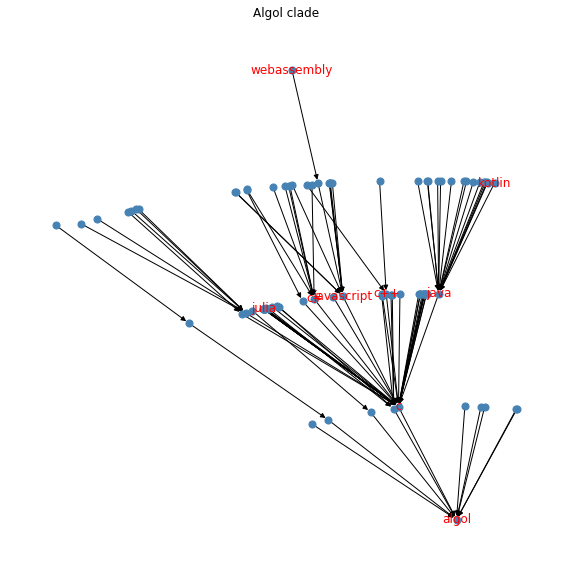

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Largest subgraph clade
subgraph = subgraphs[1]
# layout = nx.spectral_layout(subgraph)
# layout = nx.planar_layout(subgraph)

labels = defaultdict(lambda: 0)
stuff_to_label = set(["algol", "javascript", "java", "c",
                      "c++", "c#", "kotlin", "webassembly", "julia"])

for n in subgraph.nodes:
    name = nodes[n]['name']
    if name in stuff_to_label:
        labels[n] = nodes[n]['name']

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Algol clade")
nx.draw_kamada_kawai(subgraph, ax=ax, node_size=50, labels=labels, node_color='steelblue', edge_color='black', font_color="red")

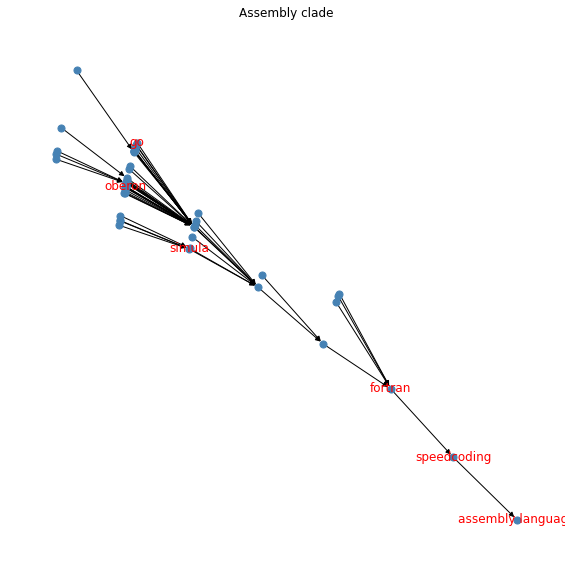

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Third Largest subgraph clade
subgraph = subgraphs[2]
# layout = nx.spectral_layout(subgraph)
# layout = nx.planar_layout(subgraph)

labels = defaultdict(lambda: 0)
stuff_to_label = set(["assembly language", "simula", "fortran", "go", "speedcoding", "oberon"])

for n in subgraph.nodes:
    name = nodes[n]['name']
    if name in stuff_to_label:
        labels[n] = nodes[n]['name']

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Assembly clade")
nx.draw_kamada_kawai(subgraph, ax=ax, node_size=50, labels=labels, node_color='steelblue', edge_color='black', font_color="red")

/Users/eoin/anaconda/lib/python3.6/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


Text(0.5, 0, 'Time')

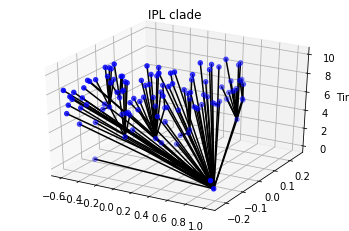

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Largest subgraph clade
subgraph = subgraphs[0]
# layout = nx.spectral_layout(subgraph)
layout = nx.planar_layout(subgraph)

# Get max and min years
max_year = -np.inf
min_year = np.inf

for nid in subgraph.nodes:
    max_year = max(max_year, nodes[nid]['year'])
    min_year = min(min_year, nodes[nid]['year'])

year_delta = max_year - min_year
height = 10

layout_3d = {}
for node in layout:
    z = height * (nodes[node]['year'] - min_year)/year_delta
    layout_3d[node] = np.append(layout[node], z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = []
ys = []
zs = []

for coord in layout_3d.values():
    xs.append(coord[0])
    ys.append(coord[1])
    zs.append(coord[2])
ax.scatter(xs,ys,zs, color="blue")

for i,j in subgraphs[0].edges:
    pos_i = layout_3d[i]
    pos_j = layout_3d[j]
    
    ax.plot([pos_i[0], pos_j[0]],[pos_i[1], pos_j[1]],[pos_i[2], pos_j[2]], color="black")

ax.set_title("IPL clade")
ax.set_zlabel("Time")

Text(0.5, 0, 'Time')

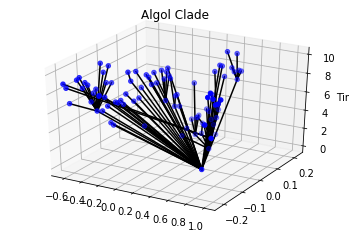

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Largest subgraph clade
subgraph = subgraphs[1]
# layout = nx.spectral_layout(subgraph)
layout = nx.planar_layout(subgraph)

# Get max and min years
max_year = -np.inf
min_year = np.inf

for nid in subgraph.nodes:
    max_year = max(max_year, nodes[nid]['year'])
    min_year = min(min_year, nodes[nid]['year'])

year_delta = max_year - min_year
height = 10

layout_3d = {}
for node in layout:
    z = height * (nodes[node]['year'] - min_year)/year_delta
    layout_3d[node] = np.append(layout[node], z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = []
ys = []
zs = []

for coord in layout_3d.values():
    xs.append(coord[0])
    ys.append(coord[1])
    zs.append(coord[2])
ax.scatter(xs,ys,zs, color="blue")

for i,j in subgraph.edges:
    pos_i = layout_3d[i]
    pos_j = layout_3d[j]
    
    ax.plot([pos_i[0], pos_j[0]],[pos_i[1], pos_j[1]],[pos_i[2], pos_j[2]], color="black")

ax.set_title("Algol Clade")
ax.set_zlabel("Time")

Text(0.5, 0, 'Time')

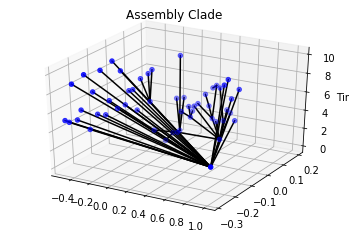

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
# Largest subgraph clade
subgraph = subgraphs[2]
# layout = nx.spectral_layout(subgraph)
layout = nx.planar_layout(subgraph)

# Get max and min years
max_year = -np.inf
min_year = np.inf

for nid in subgraph.nodes:
    max_year = max(max_year, nodes[nid]['year'])
    min_year = min(min_year, nodes[nid]['year'])

year_delta = max_year - min_year
height = 10

layout_3d = {}
for node in layout:
    z = height * (nodes[node]['year'] - min_year)/year_delta
    layout_3d[node] = np.append(layout[node], z)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = []
ys = []
zs = []

for coord in layout_3d.values():
    xs.append(coord[0])
    ys.append(coord[1])
    zs.append(coord[2])
ax.scatter(xs,ys,zs, color="blue")

for i,j in subgraph.edges:
    pos_i = layout_3d[i]
    pos_j = layout_3d[j]
    
    ax.plot([pos_i[0], pos_j[0]],[pos_i[1], pos_j[1]],[pos_i[2], pos_j[2]], color="black")

ax.set_title("Assembly Clade")
ax.set_zlabel("Time")

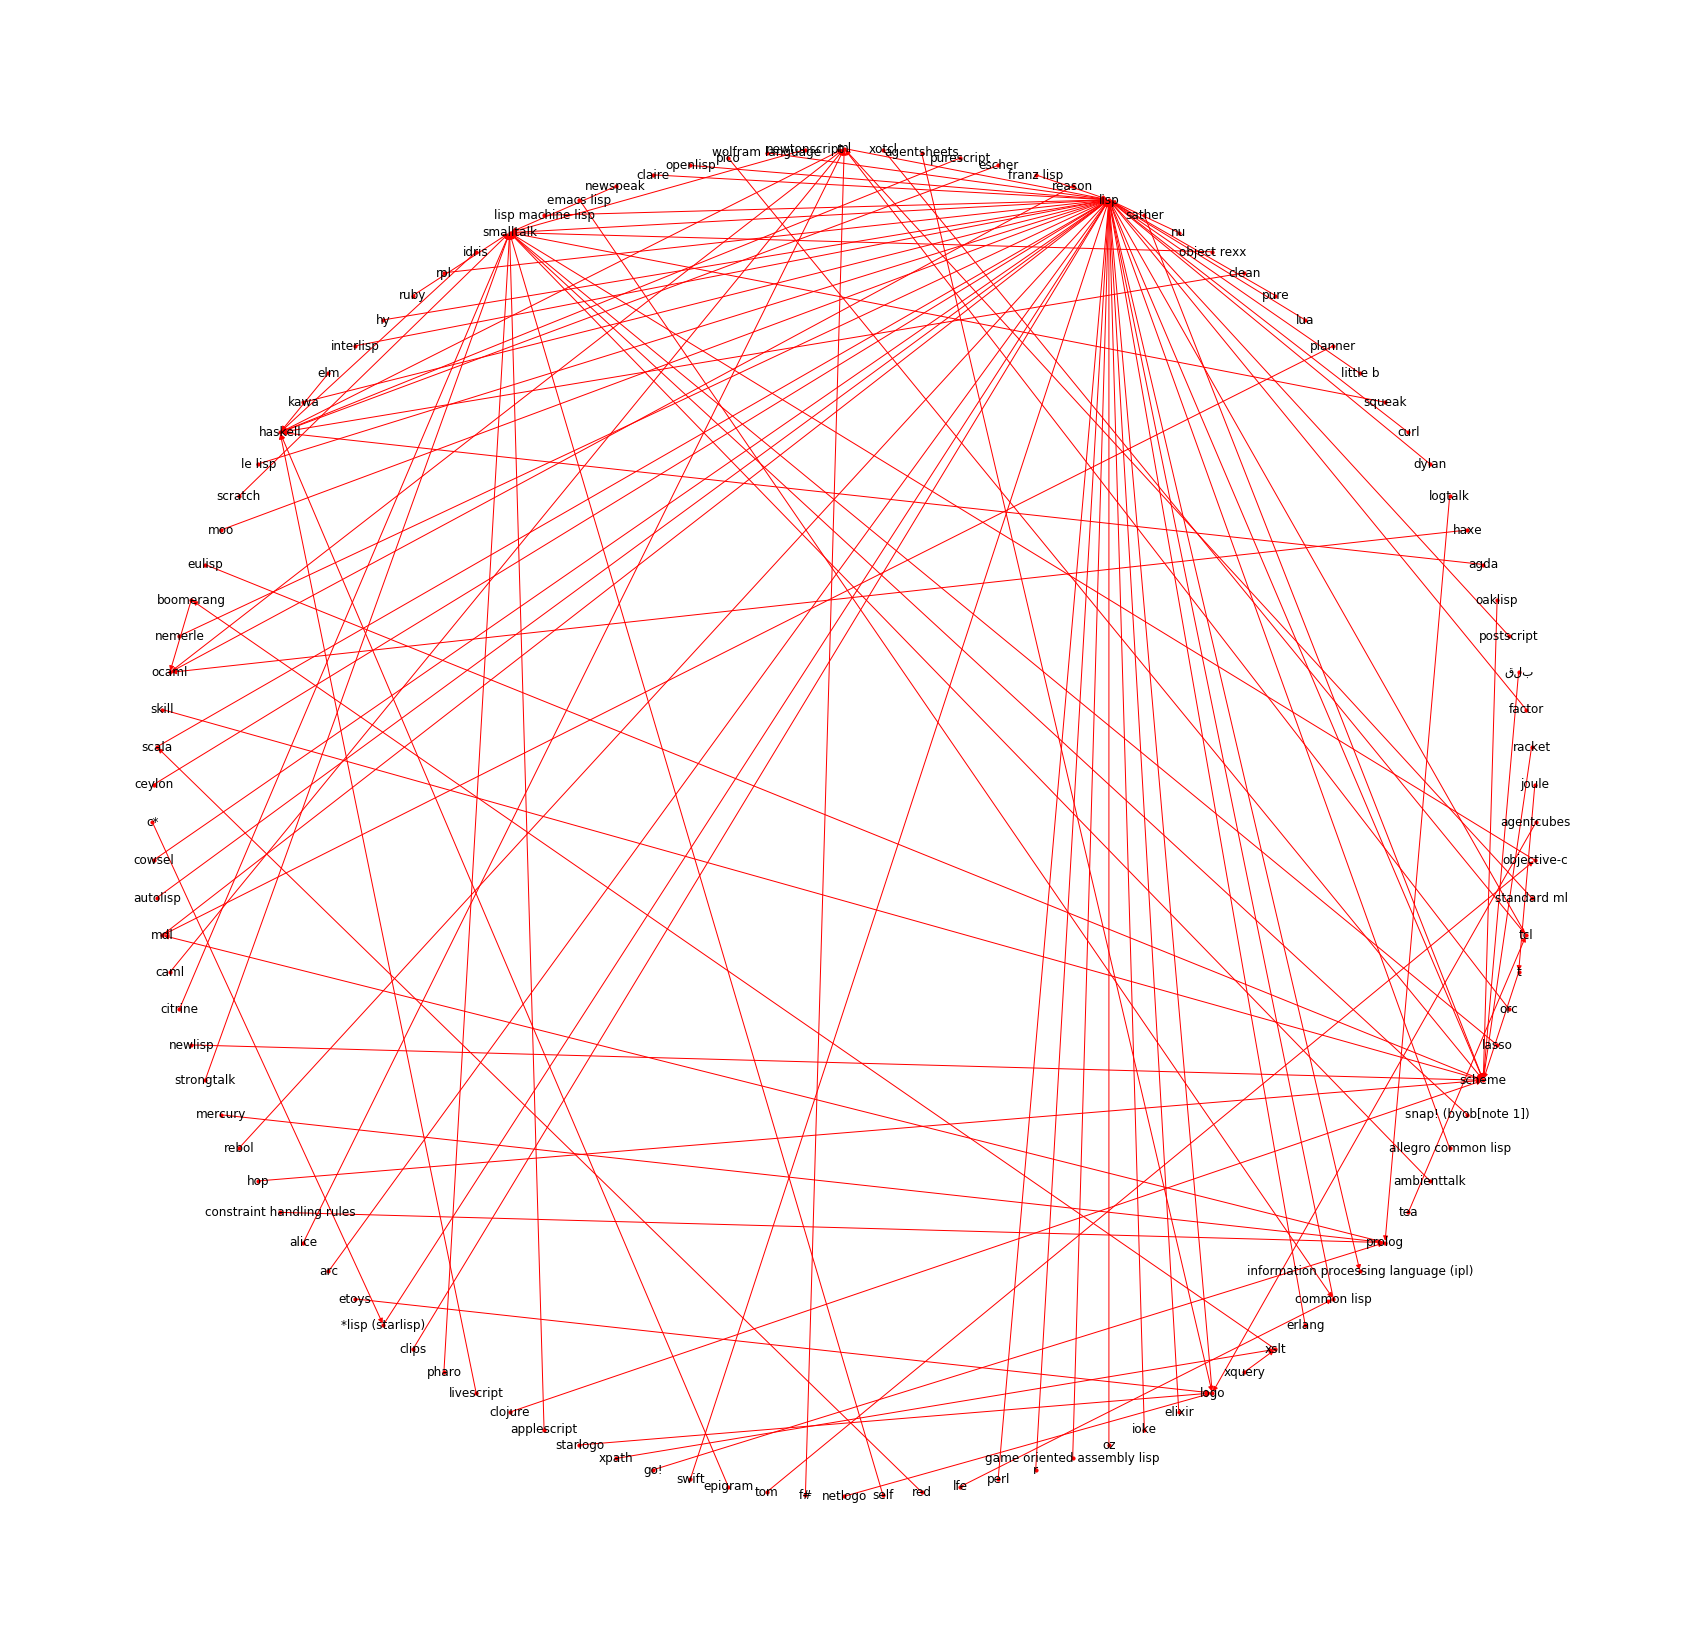

In [33]:
subgraph = subgraphs[0]
labels = {}

for node in subgraph.nodes:
    labels[node] = nodes[node]['name']

fig, ax = plt.subplots(figsize=(30,30))
nx.draw_circular(subgraph, node_size=10, ax=ax, labels=labels, edge_color='red', node_color='red')

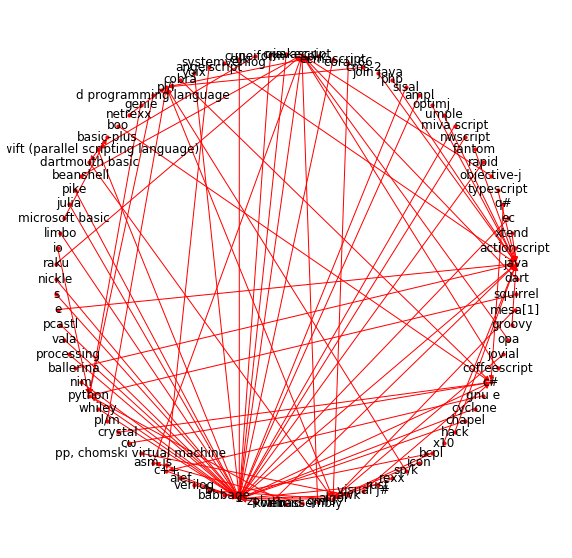

In [34]:
subgraph = subgraphs[1]
labels = {}

for node in subgraph.nodes:
    labels[node] = nodes[node]['name']

fig, ax = plt.subplots(figsize=(10,10))
nx.draw_circular(subgraph, node_size=10, ax=ax, labels=labels, edge_color='red', node_color='red')

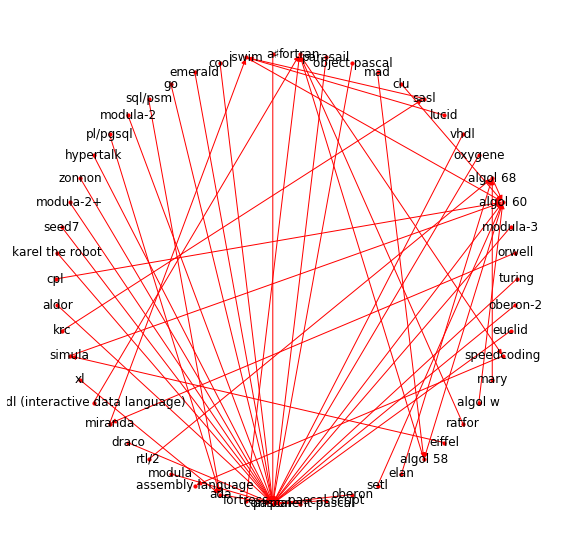

In [35]:
subgraph = subgraphs[2]
labels = {}

for node in subgraph.nodes:
    labels[node] = nodes[node]['name']

fig, ax = plt.subplots(figsize=(10,10))
nx.draw_circular(subgraph, node_size=10, ax=ax, labels=labels, edge_color='red', node_color='red')

In [36]:
for node in subgraphs[0].nodes:
    if subgraphs[0].out_degree(node) == 0:
        print(nodes[node]['name'])

information processing language (ipl)


In [37]:
for node in subgraphs[1].nodes:
    if subgraphs[1].out_degree(node) == 0:
        print(nodes[node]['name'])

algol


In [38]:
for node in subgraphs[2].nodes:
    if subgraphs[2].out_degree(node) == 0:
        print(nodes[node]['name'])

assembly language


2.4 Modeling programming language evolution

In [39]:
m = np.sum([temporal_G.out_degree(node) for node in temporal_G.nodes])/len(temporal_G.nodes)

In [40]:
def classify_neighbors(G, node):
    neighbors = set(G.neighbors(node))
    ancestor_set = set()
    
    for n in neighbors:
        for n2 in G.neighbors(n):
            ancestor_set.add(n2)
    
    ancestor_neighbors = neighbors & ancestor_set
    unique_ancestors = neighbors
    
    return unique_ancestors, ancestor_neighbors

In [41]:
def extract_pq(G, nodes, starting_n=0):
    # Assume nodes is sorted from oldest to youngest
    p_acc = 0
    q_acc = 0
    n_used = starting_n
    
    for node in nodes:
        direct_neighbors = set(G.neighbors(node))
        all_ancestors = set()
        
        for n in direct_neighbors:
            all_ancestors = all_ancestors | set(G.neighbors(n))
        connected_ancestors = direct_neighbors & all_ancestors
        if n_used != 0:
            p_acc += len(direct_neighbors) / n_used
            if len(all_ancestors) != 0:
                q_acc += len(connected_ancestors) / len(all_ancestors)
        
        n_used += 1
    
    N = len(nodes)
    p_estimate = p_acc / N
    q_estimate = q_acc / N
    return p_estimate, q_estimate

In [42]:
stage1 = []
stage2 = []

for node in temporal_nodes:
    if nodes[node]['year'] < 1982:
        stage1.append(node)
    else:
        stage2.append(node)

In [43]:
stage1.sort(key=lambda x: nodes[x]['year'])
stage2.sort(key=lambda x: nodes[x]['year'])

In [44]:
p1, q1 = extract_pq(temporal_G, stage1)

In [45]:
p2, q2 = extract_pq(temporal_G, stage2, starting_n=len(stage1))

In [46]:
print(p1, q1)
print(p2, q2)

0.04814511034461161 0.10897594072594073
0.014253421392421637 0.08848984621572233


In [47]:
def generate_GNC(p, q, iterations, seed=None, k_max=10, beta=0.1):
    out_degrees = {}
    
    if seed == None:
        seed = nx.DiGraph()
    else:
        for node in seed.nodes:
            out_degrees[node] = seed.out_degree(node)
    
    start_id = 0 if len(seed.nodes) == 0 else max(seed.nodes) + 1
    
    for i in range(start_id, start_id + iterations):
        seed.add_node(i)
        out_degrees[i] = 0
        
        neighbors = []
        
        for j in seed.nodes:
            if np.random.rand() < p/(1 + np.exp(-beta*((seed.in_degree(j) + seed.out_degree(j)) - k_max))):
                seed.add_edge(i,j)
                out_degrees[i] += 1
                neighbors += list(seed.neighbors(j))
        
        for j in neighbors:
            if np.random.rand() < q/(1 + np.exp(-beta*((seed.in_degree(j) + seed.out_degree(j)) - k_max))):
                out_degrees[i] += 1
                seed.add_edge(i,j)
    
    return seed

In [48]:
stage1_graph = generate_GNC(p1, q1, 150, k_max=5)
stage2_graph = generate_GNC(p2, q2, 250, seed=stage1_graph, k_max=10)

Text(0.5, 1.0, 'In Degree Per Node Over Time')

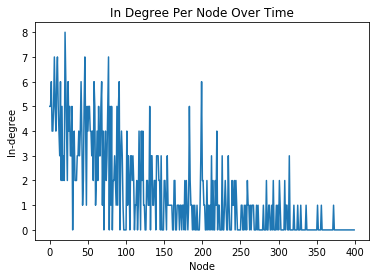

In [49]:
index = 0
xs = [i for i in range(len(stage2_graph.nodes))]
ys = [stage1_graph.in_degree(i) for i in stage1_graph.nodes]

fig, ax = plt.subplots()
ax.plot(xs, ys)
ax.set_xlabel("Node")
ax.set_ylabel("In-degree")
ax.set_title("In Degree Per Node Over Time")

In [50]:
gen_graphs = []

for i in range(100):
    stage1_graph = generate_GNC(p1, q1, 150, k_max=2, beta=0.1)
    stage2_graph = generate_GNC(p2, q2, 205, seed=stage1_graph, k_max=1, beta=0.1)
    gen_graphs.append(stage2_graph)

Figure 4 stuff

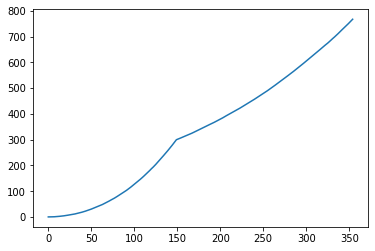

In [51]:
xs = [i for i in range(len(gen_graphs[0].nodes))]
means = []
mins = []
maxs = []

accs = [0 for i in range(len(gen_graphs))]

for i in xs:
    pt = []
    
    for j in range(len(gen_graphs)):
        accs[j] += gen_graphs[j].out_degree(i)
    means.append(np.mean(accs))
    mins.append(min(accs))
    maxs.append(max(accs))
plt.plot(xs,means)

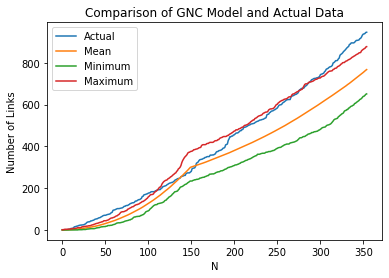

In [52]:
all_nodes = stage1 + stage2
acc = 0
ys = []
fig, ax = plt.subplots()

for node in all_nodes:
    acc += temporal_G.out_degree(node)
    ys.append(acc)

ax.plot(xs, ys, label="Actual")
ax.plot(xs,means, label="Mean")
ax.plot(xs,mins, label="Minimum")
ax.plot(xs,maxs, label="Maximum")
ax.set_xlabel("N")
ax.set_ylabel("Number of Links")
ax.set_title("Comparison of GNC Model and Actual Data")
ax.legend()

In [53]:
in_degrees = {}

for node in all_nodes:
    kin = temporal_G.in_degree(node)
    
    if kin in in_degrees:
        in_degrees[kin] += 1
    else:
        in_degrees[kin] = 1

In [54]:
out_degrees = {}

for node in all_nodes:
    kout = temporal_G.out_degree(node)
    
    if kout in out_degrees:
        out_degrees[kout] += 1
    else:
        out_degrees[kout] = 1

In [55]:
in_degrees_model = defaultdict(lambda: [0 for _ in range(len(gen_graphs))])

for i in range(len(gen_graphs)):
    graph = gen_graphs[i]
    for j in range(len(graph.nodes)):
        kin = graph.in_degree(j)
        in_degrees_model[kin][i] += 1

In [56]:
out_degrees_model = defaultdict(lambda: [0 for _ in range(len(gen_graphs))])

for i in range(len(gen_graphs)):
    graph = gen_graphs[i]
    for j in range(len(graph.nodes)):
        kout = graph.out_degree(j)
        out_degrees_model[kout][i] += 1

In [57]:
mean_model_in_deg = {}

for key in in_degrees_model:
    mean_model_in_deg[key] = np.mean(in_degrees_model[key])
    
mean_model_out_deg = {}

for key in out_degrees_model:
    mean_model_out_deg[key] = np.mean(out_degrees_model[key])

In [58]:
xs_in = list(mean_model_in_deg.keys())
ys_in = []

for x in xs_in:
    ys_in.append(mean_model_in_deg[x])

In [59]:
xs_out = list(mean_model_out_deg.keys())
ys_out = []

for x in xs_out:
    ys_out.append(mean_model_out_deg[x])

Text(0.5, 1.0, 'In-degree Freqency of Model Vs. Data')

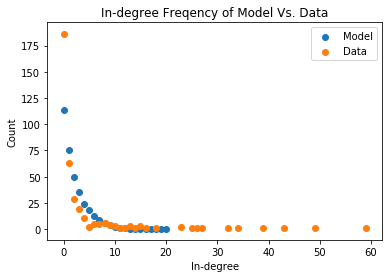

In [60]:
fig, ax = plt.subplots()

xs = list(in_degrees.keys())
ys = []

for x in xs:
    ys.append(in_degrees[x])

ax.scatter(xs_in, ys_in, label="Model")
ax.scatter(xs, ys, label="Data")
ax.legend()
ax.set_xlabel("In-degree")
ax.set_ylabel("Count")
ax.set_title("In-degree Freqency of Model Vs. Data")

Text(0.5, 1.0, 'Out-degree Freqency of Model Vs. Data')

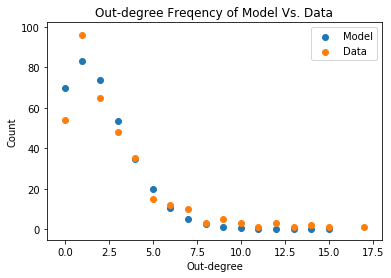

In [61]:
fig, ax = plt.subplots()

xs = list(out_degrees.keys())
ys = []

for x in xs:
    ys.append(out_degrees[x])

ax.scatter(xs_out, ys_out, label="Model")
ax.scatter(xs, ys, label="Data")
ax.legend()
ax.set_xlabel("Out-degree")
ax.set_ylabel("Count")
ax.set_title("Out-degree Freqency of Model Vs. Data")

Adaptive radiations and tree imbalance

In [62]:
def average_depth(G, root):
    return sum(nx.single_source_shortest_path_length(G, root).values())/len(G.nodes)

In [63]:
def erm(n):
    G = nx.DiGraph()
    G.add_node(0)
    leaves = [0]
    n_leaves = 1
    counter = 1
    
    for i in range(1,n,2):
        index = np.random.randint(n_leaves)
        leaf = leaves[index]
        
        G.add_edge(leaf, i)
        if i+1 <= n-1:
            G.add_edge(leaf, i+1)
        leaves.append(i)
        leaves.append(i+1)
        del leaves[index]
        n_leaves += 1
    return G

In [64]:
weak_components = list(nx.weakly_connected_components(temporal_G))
print(len(weak_components))

41


In [65]:
largest_weak = max(weak_components, key=len)

In [66]:
roots = []

for node in largest_weak:
    if temporal_G.out_degree(node) == 0:
        print(node, nodes[node]['name'], nodes[node]['year'])
        roots.append(node)

27163 sed 1974
22660 occam 1983
47774 maclisp 1966
1012894 comit 1957
13087 gw-basic 1983
82760 flow-matic 1955
29004 sql 1974
1368 assembly language 1949
140643 joss 1963
65944 plankalkül 1948
1451 apl 1966
1453 algol 1958
303031 information processing language (ipl) 1956
21866469 plex 1970


Use plankalkül as the root

In [67]:
reverse_temporal_G = nx.DiGraph()

for node in temporal_G:
    reverse_temporal_G.add_node(node)
    
    for i, j in temporal_G.edges(node):
        reverse_temporal_G.add_edge(j,i)

In [68]:
for root in roots:
    print(nodes[root]['name'], average_depth(reverse_temporal_G, root))

sed 2.9126760563380283
occam 3.0901408450704224
maclisp 3.27887323943662
comit 3.1887323943661974
gw-basic 0.028169014084507043
flow-matic 2.6985915492957746
sql 0.011267605633802818
assembly language 2.8225352112676054
joss 3.2816901408450705
plankalkül 3.36056338028169
apl 2.5605633802816903
algol 1.6
information processing language (ipl) 2.1690140845070425
plex 3.4422535211267604


In [69]:
# Starting at the oldest language
average_depth(reverse_temporal_G, 65944)

3.36056338028169

In [71]:
erm_G = erm(len(temporal_G.nodes))
average_depth(erm_G, 0)

8.090140845070422

In [72]:
p1, q1 = 0.04814511034461161, 0.10897594072594073
p2, q2 = 0.014253421392421637, 0.08848984621572233

In [77]:
year_langs = defaultdict(lambda: [])

for n in nodes:
    year = nodes[n]["year"]
    year_langs[year].append(n)

In [78]:
counter = 0
for year in year_langs:
    if year < 1982:
        counter += len(year_langs[year])

In [81]:
# Copy paste of the gnc function...
gnc_G = nx.DiGraph()
gnc_ns = []
gnc_ys = []
k_max = 2
beta = 0.1

phase1_iterations = counter
for i in range(0, phase1_iterations):
    gnc_G.add_node(i)

    neighbors = set()

    for j in gnc_G.nodes:
        if np.random.rand() < p1/(1 + np.exp(-beta*((gnc_G.in_degree(j) + gnc_G.out_degree(j)) - k_max))):
            gnc_G.add_edge(j,i)
            neighbors = neighbors | set(gnc_G.neighbors(j))

    for j in neighbors:
        if np.random.rand() < q1/(1 + np.exp(-beta*((gnc_G.in_degree(j) + gnc_G.out_degree(j)) - k_max))):
            gnc_G.add_edge(j,i)
    
    gnc_ns.append(i)
    gnc_ys.append(average_depth(gnc_G, 0))

k_max = 1
phase1_iterations = counter
for i in range(phase1_iterations, len(temporal_G.nodes)):
    gnc_G.add_node(i)

    neighbors = set()

    for j in gnc_G.nodes:
        if np.random.rand() < p2/(1 + np.exp(-beta*((gnc_G.in_degree(j) + gnc_G.out_degree(j)) - k_max))):
            gnc_G.add_edge(j,i)
            neighbors = neighbors | set(gnc_G.neighbors(j))

    for j in neighbors:
        if np.random.rand() < q2/(1 + np.exp(-beta*((gnc_G.in_degree(j) + gnc_G.out_degree(j)) - k_max))):
            gnc_G.add_edge(j,i)
    
    gnc_ns.append(i)
    gnc_ys.append(average_depth(gnc_G, 0))

In [82]:
acc = 0

for graph in gen_graphs:
    reverse_graph = nx.DiGraph()
    reverse_graph.add_nodes_from(graph.nodes)
    
    for i, j in graph.edges:
        reverse_graph.add_edge(j,i)
    
    acc += average_depth(reverse_graph, 0)
acc / len(gen_graphs)

0.9264225352112676

### Supplement stuff

Scale free distribution

In [83]:
total_deg_acc = 0
in_deg_acc = 0
out_deg_acc = 0

for n in temporal_G.nodes:
    k_in = temporal_G.in_degree(n)
    k_out = temporal_G.out_degree(n)
    
    in_deg_acc += k_in
    out_deg_acc += k_out
    total_deg_acc += k_in + k_out

n = len(temporal_G.nodes)
print("Average in degree", in_deg_acc/n)
print("Average out degree", out_deg_acc/n)
print("Average degree", total_deg_acc/n)
average_degree = total_deg_acc / n
average_in_degree = in_deg_acc / n
average_out_degree = out_deg_acc / n

Average in degree 2.664788732394366
Average out degree 2.664788732394366
Average degree 5.329577464788732


In [84]:
undirected = nx.Graph()

for node in temporal_G.nodes:
    undirected.add_node(node)

for i,j in temporal_G.edges:
    undirected.add_edge(i,j)

In [85]:
in_degrees = [temporal_G.in_degree(i) for i in temporal_G.nodes]
out_degrees = [temporal_G.out_degree(i) for i in temporal_G.nodes]
degrees = [undirected.degree(i) for i in undirected.nodes]

In [86]:
degree_counts = defaultdict(lambda: 0)

for deg in degrees:
    degree_counts[deg] += 1

xs = list(degree_counts.keys())
xs.sort()
xs = xs[1:] # Get rid of 0
n_edges = len(temporal_G.edges)

ys = [degree_counts[x]/(2*n_edges) for x in xs]

In [87]:
import plfit
from numpy.random import rand,seed

In [88]:
plfit.plfit_lsq(xs, ys)

(0.05341424094562873, -1.263030253614442)

-1.263030253614442 0.05341424094562873


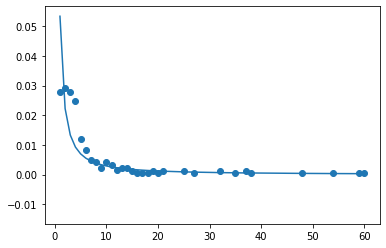

In [89]:
power_law = lambda x, k, a: a * x ** k

amp, gamma = plfit.plfit_lsq(xs, ys)
print(gamma, amp)
fig, ax = plt.subplots()
ax.scatter(xs, ys)
ax.plot(xs, [power_law(x, gamma, amp) for x in xs])
# ax.set_ylim([0,max(ys)])

$\gamma \approx 1.81$. The degree distribution is scale-free. Most languages aren't very popular.

Small world

In [90]:
# Average clustering coefficient
clustering_coeffs = nx.clustering(temporal_G)
mean_c = np.mean(list(clustering_coeffs.values()))
print(mean_c)

0.16195546148444856


In [91]:
c_rand = average_degree/n
print(f"{mean_c} >> {c_rand}")

0.16195546148444856 >> 0.015012894267010513


In [92]:
# Average shortest path length
shortest_paths = dict(nx.all_pairs_shortest_path_length(temporal_G))

In [93]:
average_shortest_paths = []

for node, d in shortest_paths.items():
    average_shortest_paths.append(np.mean(list(d.values())))
avg_avg_shortest_paths = np.mean(average_shortest_paths)

In [94]:
rand_G = nx.DiGraph()
nodes = []

for i in range(n):
    rand_G.add_node(i)
    if len(nodes) != 0:
        for _ in range(int(average_out_degree)):
            rand_G.add_edge(i, np.random.choice(nodes))
    nodes.append(i)

rand_shortest_paths = dict(nx.all_pairs_shortest_path_length(rand_G))

In [95]:
rand_avg_shortest_paths = []

for node, d in rand_shortest_paths.items():
    rand_avg_shortest_paths.append(np.mean(list(d.values())))
rand_avg_avg_shortest_paths = np.mean(rand_avg_shortest_paths)

In [96]:
print(rand_avg_avg_shortest_paths)
print(avg_avg_shortest_paths)

3.149786613068035
3.0092509479581233


The data seems to meet both of the requirements described in the paper with the caveat that the edges from each node in the random graph must be generated each time a node is added. This mimics the temporal tree-like structure of the original data.

Degree correlations

In [97]:
undirected = nx.Graph()

for node in temporal_G.nodes:
    undirected.add_node(node)

for i,j in temporal_G.edges:
    undirected.add_edge(i,j)

print(nx.degree_pearson_correlation_coefficient(undirected))

-0.24040428739635938


Disassortative mixing, but not as strong as in the paper.

Paradigms from clades

In [98]:
clade_components = list(nx.weakly_connected_component_subgraphs(temporal_clades))
clade_components.sort(key=lambda x: len(x.nodes), reverse=True)

In [99]:
largest_clades = clade_components[:5]

In [103]:
i = 0
for c in largest_clades:
    for node in c:
        if c.out_degree(node) == 0:
            print(i, nodes[node])
    i += 1

0 {'name': 'information processing language (ipl)', 'year': 1956, 'paradigm': ['Assembly'], 'typing': []}
1 {'name': 'algol', 'year': 1958, 'paradigm': ['Procedural', 'imperative', 'structured'], 'typing': []}
2 {'name': 'assembly language', 'year': 1949, 'paradigm': ['Imperative', 'unstructured'], 'typing': []}
3 {'name': 'joss', 'year': 1963, 'paradigm': [], 'typing': []}
4 {'name': 'apl', 'year': 1966, 'paradigm': ['Array', 'functional', 'structured', 'modular'], 'typing': ['dynamic']}


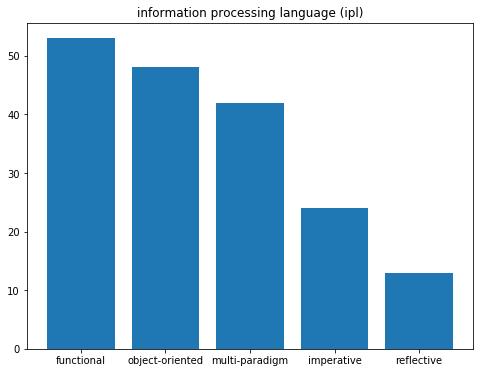

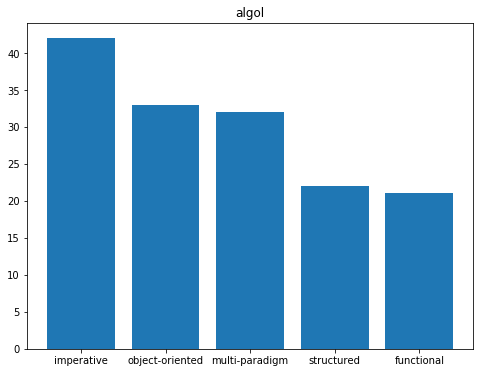

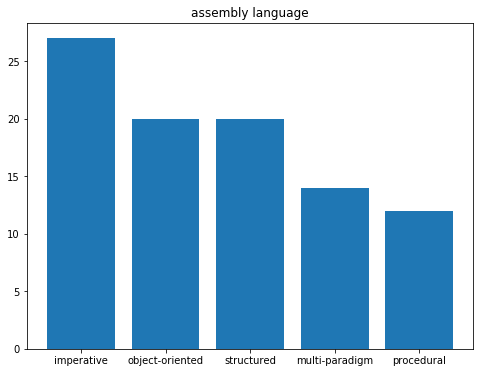

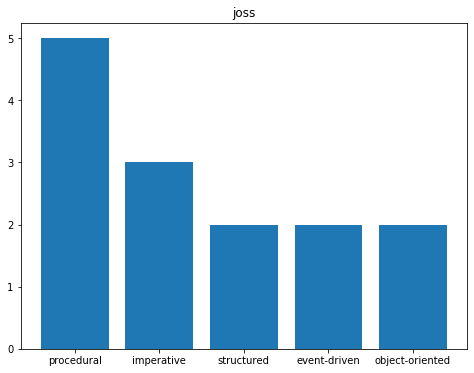

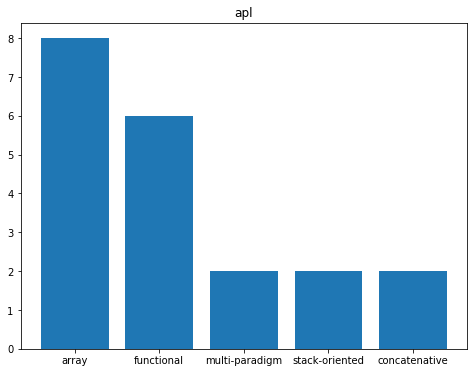

In [104]:
for c in largest_clades:
    paradigms = defaultdict(lambda: 0)
    root_name = ""
    
    for node in c.nodes:
        if c.out_degree(node) == 0:
            root_name = nodes[node]['name']
        for p in nodes[node]['paradigm']:
            paradigms[p.lower()] += 1
    fig, ax = plt.subplots(figsize=(8,6))
    
    names = list(paradigms.keys())
    names.sort(key=lambda x: paradigms[x], reverse=True)
    names = names[:5]
    
    values = [paradigms[name] for name in names]
    ax.bar(names, values)
    ax.set_title(root_name)